In [1]:
# step 1. Імпорт необхідних пакетів

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore

# step 2. Завантаження набору даних California Housing
from sklearn.datasets import fetch_california_housing

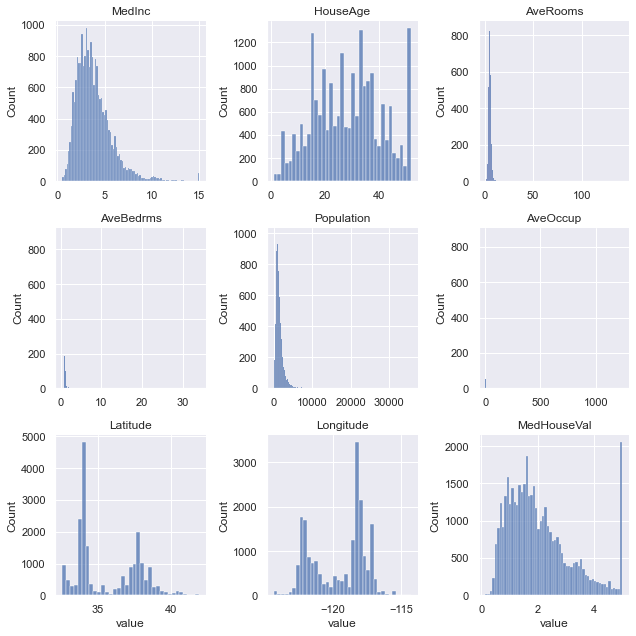

In [2]:
# step 2. Огляд даних
california = fetch_california_housing(as_frame=True)
df_basic = california.frame

# Визначення цільової змінної
#target = df_basic.pop('MedHouseVal')

# Перевірка типів даних і відсутніх значень
#df_basic.info()

# Розподіл ознак
sns.set_theme()
melted = pd.concat([df_basic, df_basic['MedHouseVal']], axis=1).melt()
g = sns.FacetGrid(melted, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, 'value') 
g.set_titles(col_template='{col_name}')
g.tight_layout()

In [3]:
# step 3. Додаткова обробка даних

In [4]:
# step 3.1. Проведення очистки від викидів для колонок:
    # AveRooms, AveBedrms, AveOccup та Population
    
# Збережемо колонки, які ми будемо очищувати від викидів у масиві
columns_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']

# Виберемо дані тільки для зазначених стовпців та застосуємо функцію zscore.
# Візьмемо її абсолютне значення для врахування позитивних і негативних відхилень.
z_scores = np.abs(df_basic[columns_to_clean].apply(zscore))

# Близько 99.7% значень знаходяться в межах трьох стандартних відхилень (Z-score між -3 та 3).
# Тому, перевіряємо, чи перевищує Z-score значення 3. Якщо так, то це значення вважається викидом/аномалією.
anomalies = (z_scores > 3)

# Застосуємо метод any(), щоб знайти і видалити всі рядки, де є хоча б одна аномалія.
# Отже, залишимо лише ті рядки, де немає аномальних значень, використовуючи інвертовану маску ~anomalies.any(axis=1).
# При інвертації міняється булевий результат False — викид, True — ні.
df_cleaned = df_basic[~anomalies.any(axis=1)]

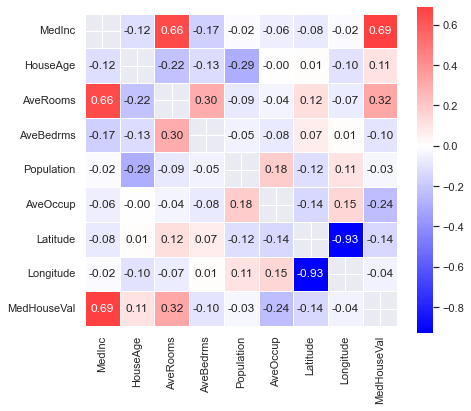

In [5]:
# step 3.2. Видалення із набору даних однієї ознаки із тих, які мають високу кореляцію між собою

corr_mtx = df_cleaned.corr()
mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)
fig, ax = plt.subplots(figsize=(7, 6))

# Розраховуємо та візуалізуємо матрицю кореляції
sns.heatmap(corr_mtx, cmap='bwr', center=0, annot=True, fmt='.2f', linewidth=0.5, square=True, mask=mask_mtx, ax=ax)
plt.show()

Вибераємо та видаляємо одну з сильно корельованих ознак.

Треба враховувати, що видалення: MedInc, HouseAge, AveRooms, Latitude, Longitude може призвести до втрати ключової інформації, що погіршить якість моделі, бо ці ознаки є важливими для формування ціни на житло.

### Аргументація важливості ознак

- **MedInc**: Вищий середній дохід населення часто корелює з вищими цінами на житло, оскільки люди з більшими доходами можуть дозволити собі дорожчі будинки.

- **HouseAge** та **AveRooms**: Вік будинку та кількість кімнат також може істотно впливати на його вартість. Новіші будинки та/або з більшою кількістю кімнат зазвичай коштують дорожче через сучасніші умови життя та знижені витрати на утримання.

- **Latitude** і **Longitude**: Місцезнаходження будинку є одним із найважливіших факторів. Райони ближче до міських центрів або в престижних зонах мають вищі ціни на житло.


Отже, у нашому випадку доцільним є видалення: AveBedrms або AveOccup

In [6]:
# Розглянемо обидва випадки
# Варіант 1
df_cleaned_AveBedrms = df_cleaned.drop(columns=['AveBedrms'])

In [7]:
# step 4. Розібиття вхідного набору даних на навчальну і тестову вибірки
# Визначення ознак та цільової змінної

X1 = df_cleaned_AveBedrms.drop(columns='MedHouseVal')
y1 = df_cleaned_AveBedrms['MedHouseVal']

# Розподіл даних на навчальну і тестову вибірки
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [8]:
# step 5. Здійснено нормалізацію ознак
scaler1 = StandardScaler().set_output(transform='pandas').fit(X_train1)
X_train_scaled1 = scaler1.transform(X_train1)
X_test_scaled1 = scaler1.transform(X_test1)

# Ознаки після нормалізації
# print(X_train_scaled1.describe())

In [9]:
# step 6. Побудова моделі
model1 = LinearRegression().fit(X_train_scaled1, y_train1) 
y_pred1 = model1.predict(X_test_scaled1) 
ymin1, ymax1 = y_train1.agg(['min', 'max']).values 
y_pred1 = pd.Series(y_pred1, index=X_test_scaled1.index).clip(ymin1, ymax1) 
# print(y_pred1.head())

In [10]:
# step 7. Оцінено показники моделі за такими метриками як: R-квадрат, MAE, MAPE
r_sq1 = model1.score(X_train_scaled1, y_train1)
mae1 = mean_absolute_error(y_test1, y_pred1)
mape1 = mean_absolute_percentage_error(y_test1, y_pred1)
print("Оцінювання точності базової моделі (видалення ознаки AveBedrms):")
print(f'R2: {r_sq1:.2f} | MAE: {mae1:.2f} | MAPE: {mape1:.2f}\n')

Оцінювання точності базової моделі (видалення ознаки AveBedrms):
R2: 0.64 | MAE: 0.50 | MAPE: 0.29



In [11]:
# step 8. Порівняно нові метрики з метриками моделі
poly1 = PolynomialFeatures(2).set_output(transform='pandas')
Xtr1 = poly1.fit_transform(X_train_scaled1)
Xts1 = poly1.transform(X_test_scaled1)
model_upd1 = LinearRegression().fit(Xtr1, y_train1)
y_pred_upd1 = model_upd1.predict(Xts1)
y_pred_upd1 = pd.Series(y_pred_upd1, index=Xts1.index).clip(ymin1, ymax1)
r_sq_upd1 = model_upd1.score(Xtr1, y_train1)
mae_upd1 = mean_absolute_error(y_test1, y_pred_upd1)
mape_upd1 = mean_absolute_percentage_error(y_test1, y_pred_upd1)
print("Побудова і оцінювання точності поліноміальної регресії (у варіанті з видаленням AveBedrms):")
print(f'R2: {r_sq_upd1:.2f} | MAE: {mae_upd1:.2f} | MAPE: {mape_upd1:.2f}')
print("---------------------------------------------------------------------------")

Побудова і оцінювання точності поліноміальної регресії (у варіанті з видаленням AveBedrms):
R2: 0.70 | MAE: 0.45 | MAPE: 0.25
---------------------------------------------------------------------------


In [12]:
# Варіант 2
df_cleaned_AveOccup = df_cleaned.drop(columns=['AveOccup'])
X2 = df_cleaned_AveOccup.drop(columns='MedHouseVal')
y2 = df_cleaned_AveOccup['MedHouseVal']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

scaler2 = StandardScaler().set_output(transform='pandas').fit(X_train2)
X_train_scaled2 = scaler2.transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)
# print(X_train_scaled2.describe())

model2 = LinearRegression().fit(X_train_scaled2, y_train2) 
y_pred2 = model2.predict(X_test_scaled2) 
ymin2, ymax2 = y_train2.agg(['min', 'max']).values 
y_pred2 = pd.Series(y_pred2, index=X_test_scaled2.index).clip(ymin2, ymax2)
# print(y_pred2.head())

r_sq2 = model2.score(X_train_scaled2, y_train2)
mae2 = mean_absolute_error(y_test2, y_pred2)
mape2 = mean_absolute_percentage_error(y_test2, y_pred2)
print("Оцінювання точності базової моделі (видалення ознаки AveOccup):")
print(f'R2: {r_sq2:.2f} | MAE: {mae2:.2f} | MAPE: {mape2:.2f}\n')

poly2 = PolynomialFeatures(2).set_output(transform='pandas')
Xtr2 = poly2.fit_transform(X_train_scaled2)
Xts2 = poly2.transform(X_test_scaled2)
model_upd2 = LinearRegression().fit(Xtr2, y_train2)
y_pred_upd2 = model_upd2.predict(Xts2)
y_pred_upd2 = pd.Series(y_pred_upd2, index=Xts2.index).clip(ymin2, ymax2)
r_sq_upd2 = model_upd2.score(Xtr2, y_train2)
mae_upd2 = mean_absolute_error(y_test2, y_pred_upd2)
mape_upd2 = mean_absolute_percentage_error(y_test2, y_pred_upd2)
print("Побудова і оцінювання точності поліноміальної регресії (у варіанті з видаленням AveOccup):")
print(f'R2: {r_sq_upd2:.2f} | MAE: {mae_upd2:.2f} | MAPE: {mape_upd2:.2f}')
print("---------------------------------------------------------------------------")

Оцінювання точності базової моделі (видалення ознаки AveOccup):
R2: 0.61 | MAE: 0.52 | MAPE: 0.31

Побудова і оцінювання точності поліноміальної регресії (у варіанті з видаленням AveOccup):
R2: 0.67 | MAE: 0.48 | MAPE: 0.27
---------------------------------------------------------------------------


# Висновки

Видалення ознаки "AveBedrms" з моделі посприяло покращенню точності прогнозів у порівнянні з початковою моделлю.


Оцінювання точності базової моделі (видалення ознаки AveBedrms):

R2: 0.64 | MAE: 0.50 | MAPE: 0.29


Побудова і оцінювання точності поліноміальної регресії:

R2: 0.70 | MAE: 0.45 | MAPE: 0.25


R2 - зросло |MAE - зменшилось на 10%| MAPE - зменшилось на ~14%

точність моделі досягає ((1 − MAPE) ⋅ 100) = ((1 − 0.25) ⋅ 100) = 75% 

Зменшення MAE на 10% показує, що модель стала ефективнішою в прогнозуванні і краще адаптується до даних, завдяки чому помилки прогнозування зменшилися. 

********************************************************************

Видалення ознаки "AveOccup" з моделі посприяло покращенню точності прогнозів у порівнянні з початковою моделлю.


Оцінювання точності базової моделі (видалення ознаки AveOccup):

R2: 0.61 | MAE: 0.52 | MAPE: 0.31


Побудова і оцінювання точності поліноміальної регресії:

R2: 0.67 | MAE: 0.48 | MAPE: 0.27


R2 - зросло |MAE - зменшилось на ~8%| MAPE - зменшилось на ~13%

точність моделі досягає ((1 − MAPE) ⋅ 100) = ((1 − 0.27) ⋅ 100) = 73% 

Зменшення MAE на ~8% показує, що модель стала ефективнішою в прогнозуванні і краще адаптується до даних, завдяки чому помилки прогнозування зменшилися. 

********************************************************************

Ці висновки показують, що видалення обох ознак призводить до покращення точності моделі, але видалення "AveBedrms" має більший позитивний ефект на точність прогнозів.
